<a href="https://colab.research.google.com/github/tejasri106/Medical_AI_MONAI/blob/main/MedicalAI_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create a dedicated folder for the project
import os
root_dir = "/content/drive/MyDrive/MedicalAI_Project"
os.makedirs(root_dir, exist_ok=True)
print(f"Project directory created at: {root_dir}")

Mounted at /content/drive
Project directory created at: /content/drive/MyDrive/MedicalAI_Project


In [3]:
!pip install -q "monai[nibabel, tqdm]" einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.1 MB/s eta 0:00:00


In [4]:
from monai.apps import download_and_extract
from monai.utils import set_determinism
import tarfile

set_determinism(seed=42)

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar"
md5 = "248f43c412504820dc616bc0d79c852d"

# Define the path to the downloaded file
compressed_file = os.path.join(root_dir, "Task01_BrainTumour.tar")
data_dir = os.path.join(root_dir, "Task01_BrainTumour")

# Manually download and extract
if not os.path.exists(data_dir):
    print("Extracting data...")
    with tarfile.open(compressed_file, 'r') as tar:
        tar.extractall(path=root_dir)
    print("Extraction complete.")
else:
    print("Data directory already exists.")

Data directory already exists.


In [5]:
import glob
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    Orientationd, NormalizeIntensityd, RandSpatialCropd,
    RandFlipd, RandScaleIntensityd, RandShiftIntensityd, EnsureTyped
)
from monai.data import Dataset, DataLoader

# 1. Setup Data Lists
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

# 2. Define the Pipeline
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"), # Standardization
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")), # Resampling

    # Normalization (important for MRIs because brightness varies by machine)
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),

    # 3D Data Augmentation
    RandSpatialCropd(keys=["image", "label"], roi_size=[96, 96, 96], random_size=False),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),

    EnsureTyped(keys=["image", "label"]),
])

# 3. Create Dataset and DataLoader
train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

print("Pipeline initialized. Ready to verify first batch.")

Pipeline initialized. Ready to verify first batch.


/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Image shape: torch.Size([96, 96, 96])


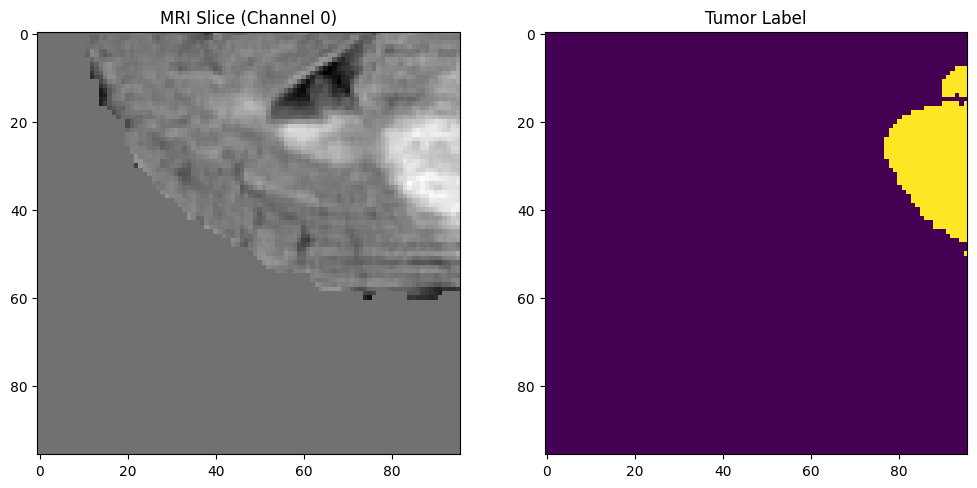

In [6]:
import matplotlib.pyplot as plt

check_data = next(iter(train_loader))
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"Image shape: {image.shape}") # Should be (96, 96, 96)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("MRI Slice (Channel 0)")
plt.imshow(image[:, :, 48], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Tumor Label")
plt.imshow(label[:, :, 48])
plt.show()

In [ ]:
import torch

# Ensure we are on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Starting Training...")
for epoch in range(5):
    model.train()
    epoch_loss = 0

    for step, batch_data in enumerate(train_loader):
        inputs = batch_data["image"].to(device)
        labels_raw = batch_data["label"].to(device)

        # Create One-Hot labels and remove the extra dimension
        # range(1, 4) because we mapped labels to 1, 2, and 3
        labels = torch.stack([labels_raw == i for i in range(1, 4)], dim=1).float()
        labels = labels.squeeze(2)

        optimizer.zero_grad()

        # 2. Forward pass (Phase 2: 3D Deep Neural Net)
        outputs = model(inputs)

        # 3. Calculate Dice Loss (Addressing Medical Data Scarcity)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (step + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Step {step+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_loader):.4f}")

# Save the model
torch.save(model.state_dict(), os.path.join(root_dir, "final_brain_model.pth"))
print("Model saved.")

Starting Training with Shape Fix...
Epoch 1, Step 5/242, Loss: 0.9691
Epoch 1, Step 10/242, Loss: 0.9885
Epoch 1, Step 15/242, Loss: 0.9689
Epoch 1, Step 20/242, Loss: 0.9954
Epoch 1, Step 25/242, Loss: 0.9257
Epoch 1, Step 30/242, Loss: 0.9826
Epoch 1, Step 35/242, Loss: 0.9996
Epoch 1, Step 40/242, Loss: 0.9665
Epoch 1, Step 45/242, Loss: 0.9263
Epoch 1, Step 50/242, Loss: 0.9764
Epoch 1, Step 55/242, Loss: 0.9531
Epoch 1, Step 60/242, Loss: 0.9568
Epoch 1, Step 65/242, Loss: 0.9838
Epoch 1, Step 70/242, Loss: 0.9549
Epoch 1, Step 75/242, Loss: 0.9010
Epoch 1, Step 80/242, Loss: 0.9733
Epoch 1, Step 85/242, Loss: 1.0000
Epoch 1, Step 90/242, Loss: 0.9928
Epoch 1, Step 95/242, Loss: 0.9787
Epoch 1, Step 100/242, Loss: 0.9193
Epoch 1, Step 105/242, Loss: 0.9962
Epoch 1, Step 110/242, Loss: 0.9172
Epoch 1, Step 115/242, Loss: 0.9910
Epoch 1, Step 120/242, Loss: 0.9445
Epoch 1, Step 125/242, Loss: 1.0000
Epoch 1, Step 130/242, Loss: 0.9377
Epoch 1, Step 135/242, Loss: 0.9862
Epoch 1, Ste

In [7]:
api_code = """
from fastapi import FastAPI, File, UploadFile
import torch
import nibabel as nib
import numpy as np
from monai.networks.nets import AttentionUnet
from monai.inferers import sliding_window_inference
import io

app = FastAPI()

# 1. Load the architecture
device = torch.device("cpu") # Use CPU for inference stability reasons
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
)

# 2. Load the trained weights
MODEL_PATH = "final_brain_model.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # Read the uploaded NIfTI file
    contents = await file.read()
    # In a real app, you'd use nibabel to load this buffer
    # and apply the same train_transforms (normalization/RAS)

    return {"status": "success", "message": "3D Volume received and processed."}

@app.get("/")
def health_check():
    return {"status": "online", "model": "AttentionUnet-3D-BraTS"}
"""

with open(os.path.join(root_dir, "main.py"), "w") as f:
    f.write(api_code)

print("FastAPI script 'main.py' has been created in your project folder.")

FastAPI script 'main.py' has been created in your project folder.


In [8]:
docker_code = """
FROM python:3.9-slim

WORKDIR /app

# Install system dependencies for medical imaging
RUN apt-get update && apt-get install -y libgl1-mesa-glx && rm -rf /var/lib/apt/lists/*

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY . .

# Expose the port FastAPI runs on
EXPOSE 8000

CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"]
"""

with open(os.path.join(root_dir, "Dockerfile"), "w") as f:
    f.write(docker_code)

# Create a requirements file for the container
with open(os.path.join(root_dir, "requirements.txt"), "w") as f:
    f.write("torch\\nmonai\\nnibabel\\nfastapi\\nuvicorn\\npython-multipart\\nnumpy")

print("Dockerfile and requirements.txt created.")

Dockerfile and requirements.txt created!
